In [1]:
import tifffile
import numpy as np
from matplotlib import pyplot as plt
import os
import napari
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
from scipy.ndimage import zoom
from napari.utils.notifications import show_info
from natsort import os_sorted
import tkinter
from tkinter import filedialog
from scipy import ndimage
import cv2
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
import scipy
from scipy.ndimage import gaussian_filter1d


In [2]:

def fwhm_along_axis(y, spacing, plot = False):
    # Maximum normalization
    y_norm = [i/max(y) for i in y]
    # create x values for plot based on the intensity values y considering the spacing
    x = [(i) * spacing for i in range(len(y_norm))]

    # find fwhm of plot
    spline = UnivariateSpline(x, y_norm-np.max(y_norm)/2, s=0)
    r1, r2 = spline.roots()
    fwhm = abs(abs(r1) - abs(r2))

    # return fwhm
    return [fwhm]
'''

def fwhm_along_axis(y, spacing, plot = False):
    # Maximum normalization
    y = gaussian_filter1d(y, sigma=1)
    y_norm = [i/max(y) for i in y]
    # create x values for plot based on the intensity values y considering the spacing
    x = [(i) * spacing for i in range(len(y_norm))]
    y_norm = y_norm-np.max(y_norm)/2
    # find fwhm of plot
    peak = np.max(y_norm)
    half_max = peak / 2

    # Shift s down by half-maximum to find where it crosses zero
    s_shifted = y_norm - half_max

    # Fit a spline to the shifted data
    spline = UnivariateSpline(x, s_shifted, s=0)
    
    if len(spline.roots()) == 1:
        fwhm = 0
    elif len(spline.roots()) == 2:
        r1, r2 = spline.roots()
        fwhm = abs(abs(r1) - abs(r2))
    else:
        fwhm = 0
        #print(len(spline.roots()))
        #plt.plot(x, s_shifted)
        #plt.show()
    # return fwhm
    return [fwhm]
'''

def get_fwhm(bbox, spacing_xy, spacing_z):
    # find max intensity
    max_coor = np.unravel_index(np.argmax(bbox), bbox.shape)
    xy_maxint = np.max(bbox, axis=0)
    xz_maxint = np.max(bbox, axis=1)
    # get intensity lines
    y_line = xy_maxint[int(max_coor[1]),:]
    x_line = xy_maxint[:,int(max_coor[2])]
    z_line = xz_maxint[:,int(max_coor[2])]
    # get fwhm
    fwhm_x = fwhm_along_axis(x_line, spacing_xy)
    fwhm_y = fwhm_along_axis(y_line, spacing_xy)
    fwhm_z = fwhm_along_axis(z_line, spacing_z)
    # return fwhm
    return [fwhm_x[0], fwhm_y[0], fwhm_z[0]], max_coor[0]
    

def apply_bbox_and_fwhm(img, psf, bbox_size = 10, spacing_xy = 0.06484, spacing_z = 0.06484):
    
    # make bounding box
    upper = [int(psf[0] + bbox_size/2), int(psf[1] + bbox_size/2)]
    lower = [int(psf[0] - bbox_size/2), int(psf[1] - bbox_size/2)]
    bbox = img[:,lower[0]:upper[0], lower[1]:upper[1]]
    fwhm_list, coor_z = get_fwhm(bbox, spacing_xy, spacing_z)
    
    return np.array(fwhm_list)*1000, coor_z

# extracting all the beads
def connected_component_analysis(stack, threshold = 10000):
    max_plane = np.max(stack, axis = 0)
    binary_mask = (max_plane >= threshold).astype(np.uint8)
    # connected component analysis
    labeled_mask, num_features = ndimage.label(binary_mask)
    centroids = ndimage.center_of_mass(binary_mask, labeled_mask, range(1, num_features + 1))
    
    return centroids

def load_datasets(paths):
    stacks = []
    for path in paths:
        if path.endswith('.tif'):
            stack = tifffile.imread(path)
            stacks.append(stack)
        else:
            # open folder
            files = os_sorted(os.listdir(path))
            stack = []
            for file in files:
                if file.endswith('.tif'):
                    stack.append(tifffile.imread(os.path.join(path, file)))
            stacks.append(np.array(stack))
    return np.array(stacks)

def shift_stack_lateral(stack, xy_shift=(0,0)):
    rolled = np.roll(stack, xy_shift[0], axis=[0])
    shift = np.roll(rolled,xy_shift[1], axis=[1])  

def reshape_tiff_data(data, num_channels):
    # Initialize the output array with the desired shape (3, 250, 500, 500)
    zsteps = len(data)//num_channels
    output = np.zeros((num_channels, zsteps, data.shape[1], data.shape[2]), dtype=np.uint16)


    # Iterate over the z-steps
    for z in range(len(data)//num_channels):
        if z % 2 == 0:
            for c in range(num_channels):
                output[c, z] = data[z * num_channels + c]
        else:
            for c in range(num_channels):
                ci = num_channels - c - 1
                output[ci, z] = data[z * num_channels + c]
    return output


def add_peak_textbox(ax, data, bins=100):
    hist, bin_edges = np.histogram(data, bins=40)  # Use the same number of bins as in the plot
    peak_bin_index = np.argmax(hist)
    peak_value = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2  # Use the middle of the bin
    ax.text(0.95, 0.95, f'Peak: {peak_value:.2f} nm', 
            transform=ax.transAxes, 
            horizontalalignment='right', 
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Detect PSFs automatically

In [3]:
import os
import json
import tkinter
from tkinter import filedialog
from natsort import os_sorted
import tifffile

In [4]:
# open file dialog to select the folder
root = tkinter.Tk()
root.withdraw()
path = filedialog.askdirectory()
#path = 'C:/Users/alm/Documents/ImSwitchConfig/recordings/2024-10-22/closed_slit_dualcolor_rec_thorlabscam'
print(path)

C:/Users/alm/Documents/ImSwitchConfig/recordings/2025-02-12/beads_rec_thorlabscam_1


In [5]:
def reshape_tiff_data(data, num_channels):
    # Initialize the output array with the desired shape (3, 250, 500, 500)
    zsteps = len(data)//num_channels
    output = np.zeros((num_channels, zsteps, data.shape[1], data.shape[2]), dtype=np.uint16)


    # Iterate over the z-steps
    for z in range(len(data)//num_channels):
        if z % 2 == 0:
            for c in range(num_channels):
                output[c, z] = data[z * num_channels + c]
        else:
            for c in range(num_channels):
                ci = num_channels - c - 1
                output[ci, z] = data[z * num_channels + c]

    return output

def load_datasets(path):

    # open folder
    files = os_sorted(os.listdir(path))
    stack = []
    for file in files:
        if file.endswith('.tif'):
            stack.append(tifffile.imread(os.path.join(path, file)))
    return np.array(stack)

In [6]:
metadata_file = 'metadata.json'

files = os_sorted(os.listdir(path))
if metadata_file in files:
    metadata = json.load(open(os.path.join(path, metadata_file)))
    z_spacing = metadata['sample_stage_step_size']
    xy_pixelsize = metadata['detector_pixel_size']
    channels = [f"ex {metadata['channels'][i]['laser_name']} em {metadata['channels'][i]['emission_filter']}" for i in metadata['channels']]

else:
    metadata = None
    z_spacing=1.1261
    xy_pixelsize=0.345
    channels=['channel 1', 'channel 2']

stacks = reshape_tiff_data(load_datasets(path), len(channels))
print(stacks.shape)

(1, 500, 2160, 4096)


In [7]:
# save the stacks
#tifffile.imwrite(path + '_stacks.tif', stacks)

In [8]:
crop_stack = stacks
del stacks

In [9]:
print(crop_stack.shape)

(1, 500, 2160, 4096)


In [10]:
def get_points(stack, spacing_xy=0.345, spacing_z=1.1261, threshold = 50):
    points = {}
    all_fwhm = {}
    
    for c in range(stack.shape[0]):
        i = 0
        components = connected_component_analysis(stack[c], threshold=threshold)
        all_fwhm[c] = []
        points[c] = []
        for point in components:
            try:
                fwhm_xyz, coor_z = apply_bbox_and_fwhm(stack[c], point, bbox_size=20, spacing_xy=spacing_xy, spacing_z=spacing_z)
                points[c].append([coor_z, point[0], point[1]])
                all_fwhm[c].append(fwhm_xyz)
            except ValueError:
                i+=1
        print(f'Channel {c} - {len(points[c])} beads found')
        print(f'Channel {c} - {i} ValueErrors not analyzed')
        all_fwhm[c] = np.array(all_fwhm[c])
        points[c] = np.array(points[c])
    return points, all_fwhm

In [11]:
points, all_fwhm = get_points(crop_stack, spacing_z=z_spacing, spacing_xy=xy_pixelsize)

Channel 0 - 5578 beads found
Channel 0 - 148873 ValueErrors not analyzed


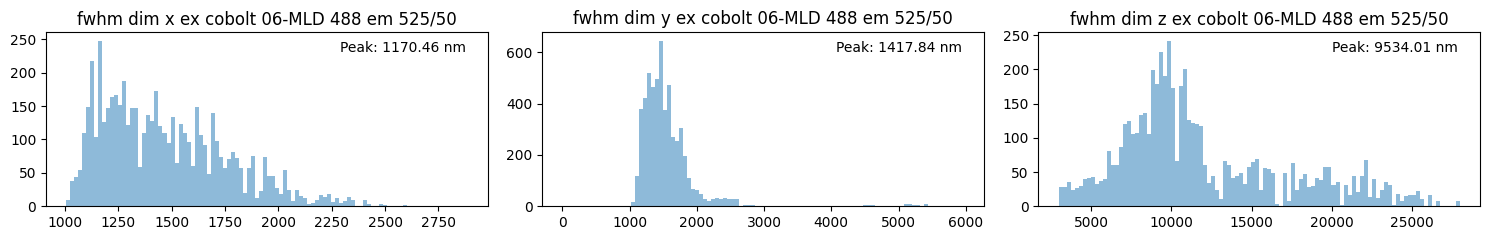

In [12]:
def add_peak_textbox(ax, data, bins=100):
    hist, bin_edges = np.histogram(data, bins=40)  # Use the same number of bins as in the plot
    peak_bin_index = np.argmax(hist)
    peak_value = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2  # Use the middle of the bin
    ax.text(0.95, 0.95, f'Peak: {peak_value:.2f} nm', 
            transform=ax.transAxes, 
            horizontalalignment='right', 
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

def plot_histogram(all_fwhm, channels, bins=100, axes=['x', 'y', 'z']):
    fig, axs = plt.subplots(len(channels), 3, figsize=(15, 2.5*len(points.keys())))
    for c in all_fwhm.keys():
        for dims in range(len(axes)):
            if len(channels) == 1:
                axs[dims].hist(all_fwhm[c][:, dims], bins=bins, alpha=0.5, label='ch1')
                axs[dims].set_title(f'fwhm dim {axes[dims]} ' + channels[c])  # Use c_idx for channels
                add_peak_textbox(axs[dims], all_fwhm[c][:, dims])  # Correctly reference the ax
            else:
                axs[c, dims].hist(all_fwhm[c][:, dims], bins=bins, alpha=0.5, label='ch1')
                axs[c, dims].set_title(f'fwhm dim {axes[dims]} ' + channels[c])  # Use c_idx for channels
                add_peak_textbox(axs[c, dims], all_fwhm[c][:, dims])  # Correctly reference the ax
        
    plt.tight_layout()
    plt.show()

plot_histogram(all_fwhm, channels)

In [13]:
def abbe(NA = 0.28, emission_wavelength = 525):
    return emission_wavelength/(2*NA)

def filter_psfs(all_fwhm, channels = ['525/50'], max_fwhm_x_plus_y=5000, max_fwhm_z=20000):  # in nm
    filtered_fwhm = {}
    filtered_points = {}
    for c in all_fwhm.keys():
        filtered_fwhm[c] = []
        filtered_points[c] = []
        for i in range(len(all_fwhm[c])):
            fwhm_x = all_fwhm[c][i, 1]
            fwhm_y = all_fwhm[c][i, 0]
            fwhm_z = all_fwhm[c][i, 2]
            if fwhm_x + fwhm_y < max_fwhm_x_plus_y and fwhm_z < max_fwhm_z:
                filtered_fwhm[c].append([fwhm_x, fwhm_y, fwhm_z])
                filtered_points[c].append(points[c][i])
        filtered_fwhm[c] = np.array(filtered_fwhm[c])
        filtered_points[c] = np.array(filtered_points[c])
    
        avg = np.mean(filtered_fwhm[c], axis=0) 
        sd = np.std(filtered_fwhm[c], axis=0) 
        print('- {}, Number of beads selected: {}'.format(channels[c], filtered_fwhm[c].shape[0]))
        print('- X FWHM is {:.4f} +/- {:4f} nm'.format(avg[0], sd[0]))
        print('- Y FWHM is {:.4f} +/- {:4f} nm'.format(avg[1], sd[1]))
        print('Abbe lateral resoluton: {:.4f} nm'.format(abbe(NA=0.28, emission_wavelength=525)))
        print('- Z FWHM is {:.4f} +/- {:4f} nm'.format(avg[2], sd[2]))
        print('____________________________________________')
    return filtered_points, filtered_fwhm

filtered_points, filtered_fwhm = filter_psfs(all_fwhm, channels=channels)


- ex cobolt 06-MLD 488 em 525/50, Number of beads selected: 4906
- X FWHM is 1480.9233 +/- 282.463123 nm
- Y FWHM is 1438.5399 +/- 283.699374 nm
Abbe lateral resoluton: 937.5000 nm
- Z FWHM is 10631.7633 +/- 3847.920373 nm
____________________________________________


Axial PSF within ROI: 1650.4038853812756, ROI shape: (4096, 489)
Axial PSF within ROI: 1556.6909704981856, ROI shape: (4096, 489)
Axial PSF within ROI: 4160.429002819494, ROI shape: (4096, 489)


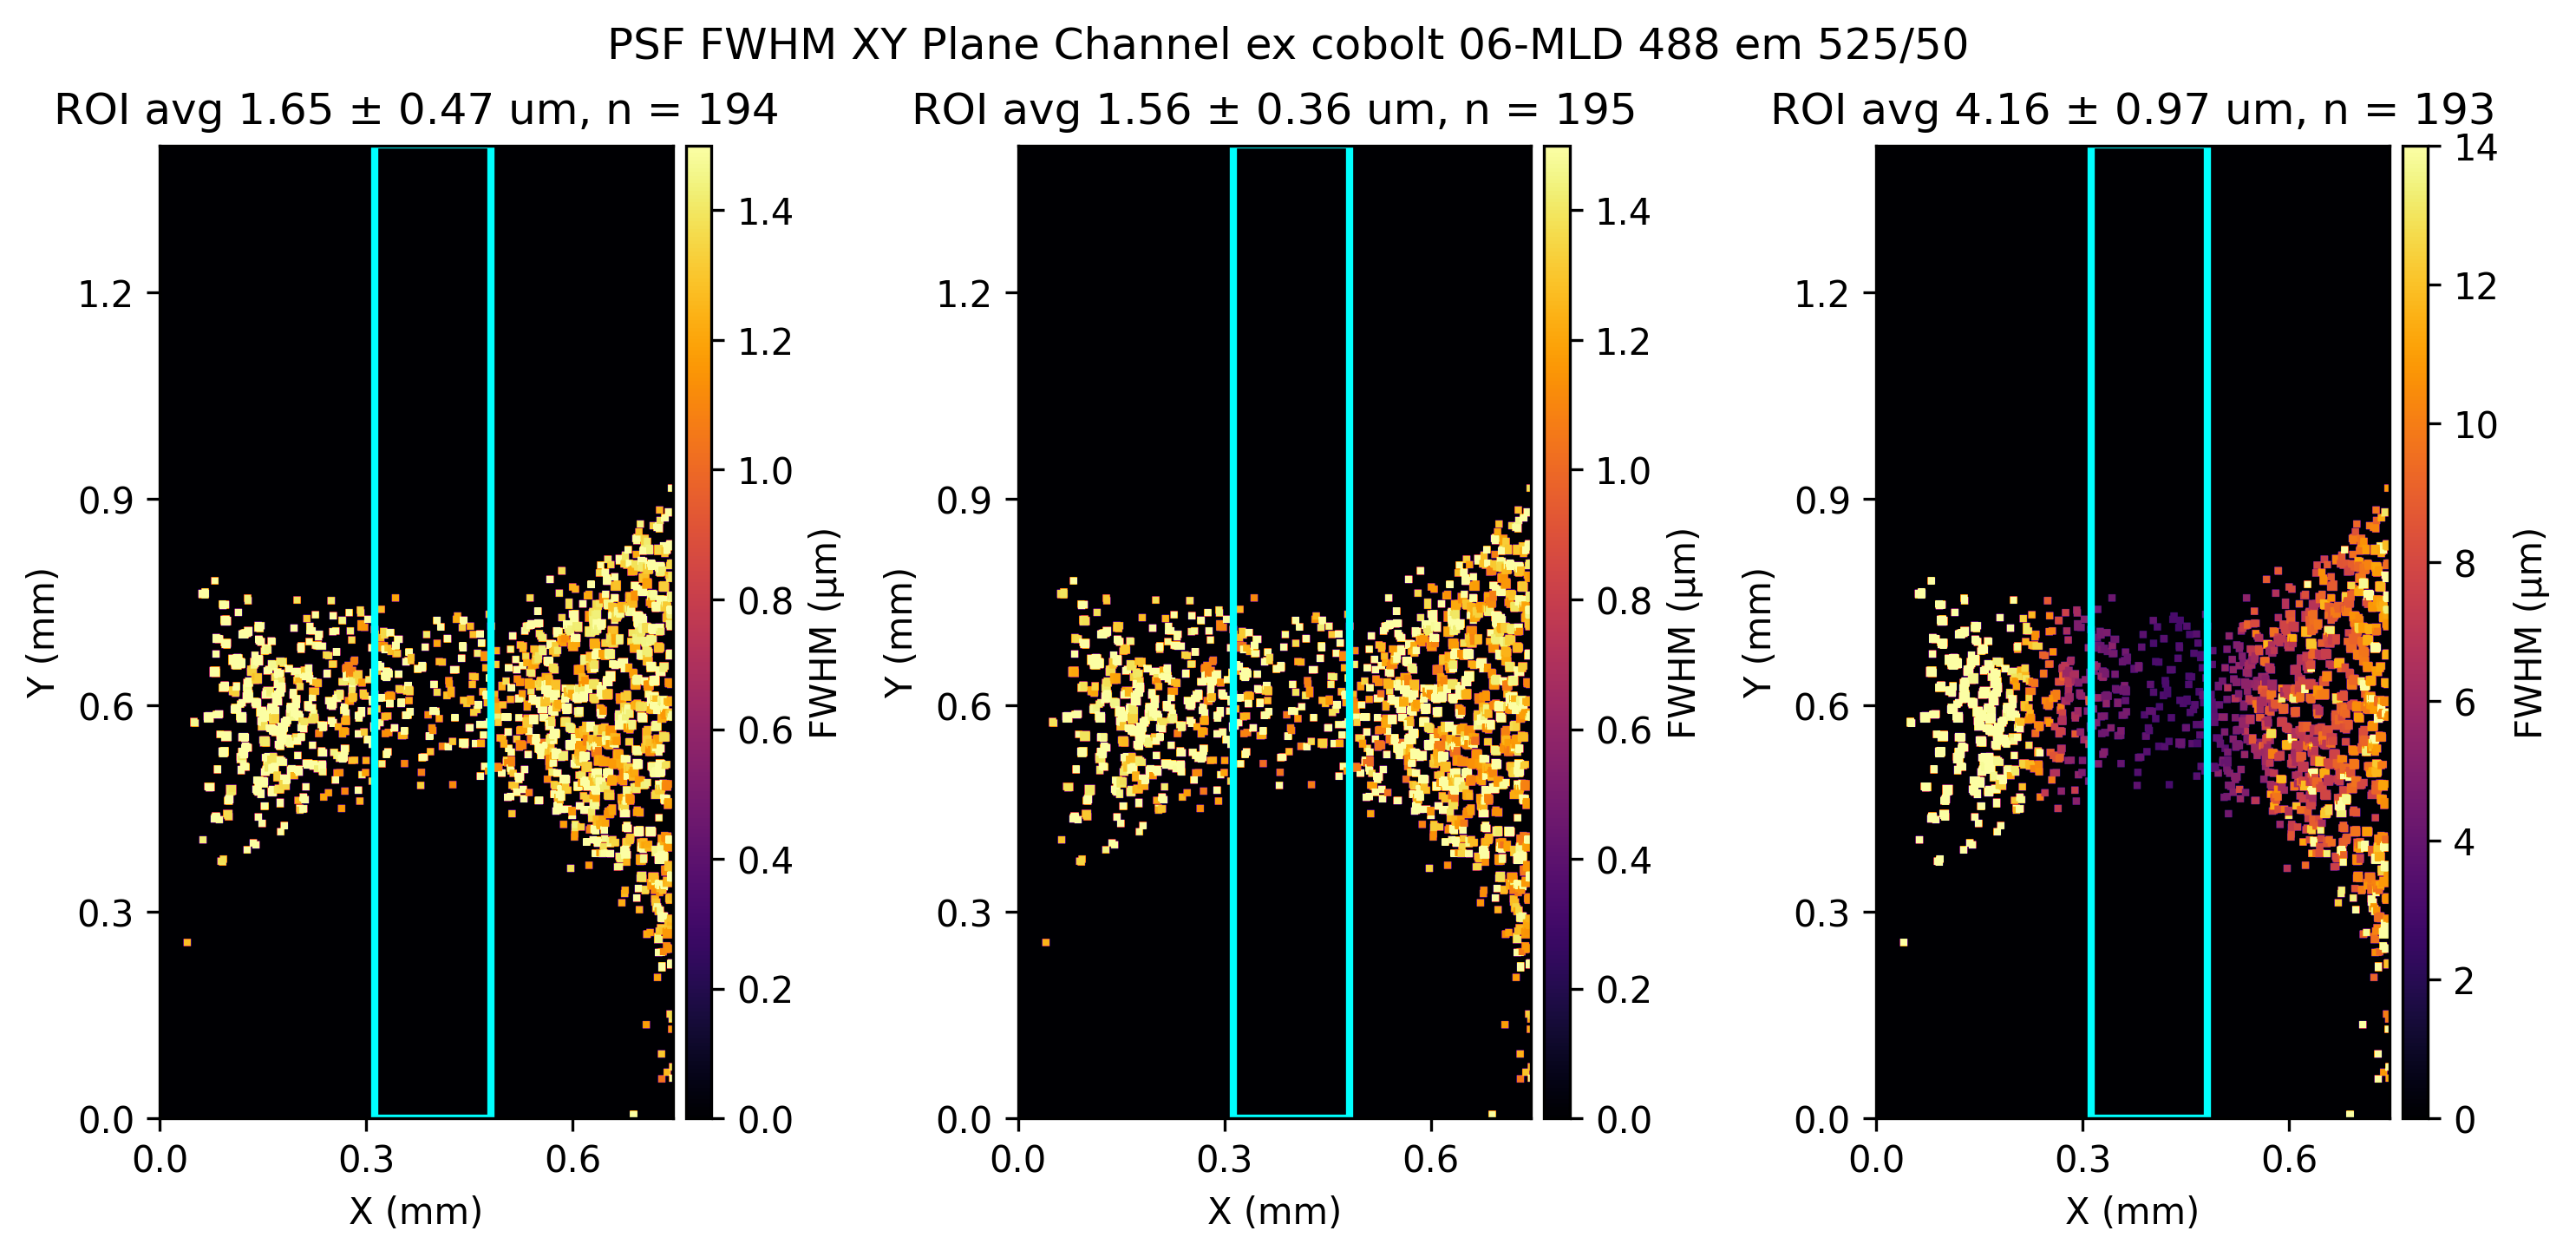

In [14]:
from matplotlib.ticker import FuncFormatter
def add_square(grid, x, y, value, size=30):
    x_start = max(0, x - size // 2)
    x_end = min(grid.shape[1], x + size // 2 + 1)
    y_start = max(0, y - size // 2)
    y_end = min(grid.shape[0], y + size // 2 + 1)
    grid[y_start:y_end, x_start:x_end] = value

def plot_2D_channel(x, y, x_shape, y_shape, all_fwhm, title='psf',ytitle=0.63, ROI_scale=None, xshift=0, spotsize=30, scale_x = 1, pixel_size = 0.345):

    fig, axs = plt.subplots(1, 3, figsize=(10, 15), dpi=300)
    fig.suptitle(title, y=ytitle)
    dim = ['X', 'Y', 'Z']
    for dims in range(all_fwhm.shape[1]):
        grid = np.zeros((x_shape, y_shape))
        for i in range(len(x)):
            add_square(grid, int(x[i]), int(y[i]), all_fwhm[i, dims], size=spotsize)
        scaled_grid = scipy.ndimage.zoom(grid, (1, scale_x), order=1)/1000
        if dims < 2:
            im = axs[dims].imshow(scaled_grid, cmap='inferno', vmin=0, vmax=1.5)#, origin='lower', extent=[0.5, x_max+0.5, 0.5, y_max+0.5])
        else:
            im = axs[dims].imshow(scaled_grid, cmap='inferno', vmin=0, vmax=14)

        # Set axis labels
        axs[dims].set_xlabel('X (mm)')
        axs[dims].set_ylabel('Y (mm)')

        # Calculate tick positions and labels
        tick_step = 300  # Desiredaa step size in unscaled units
        max_x = y_shape * pixel_size
        max_y = x_shape * pixel_size

        xticks = np.arange(0, y_shape, int(tick_step / pixel_size))  # Tick positions (grid units)
        yticks = np.arange(0, x_shape, int(tick_step / pixel_size))

        # Ensure ticks are within the range
        xticks = xticks[xticks < y_shape]
        yticks = yticks[yticks < x_shape]

        # Labels corresponding to the unscaled tick values
        xtick_labels = [str(round((int(tick * pixel_size)+1)*0.001, 1)) for tick in xticks]
        ytick_labels = [str(round((int(tick * pixel_size)+1)*0.001, 1)) for tick in yticks]

        # Set ticks and labels
        axs[dims].set_xticks(xticks)
        axs[dims].set_xticklabels(xtick_labels)
        axs[dims].set_yticks(yticks)
        axs[dims].set_yticklabels(ytick_labels)
        axs[dims].invert_yaxis()

        divider = make_axes_locatable(axs[dims])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax, label='FWHM (\u03bcm)')



        if ROI_scale!=None:   
            xy_tuple = (int(y_shape*0.5)-int((y_shape*ROI_scale)/2) + xshift,0)
            roi_values = grid[0:x_shape,xy_tuple[0]:xy_tuple[0]+int(y_shape*ROI_scale)]
            non_zero_values = roi_values[roi_values > 0]

            if len(non_zero_values) > 0:
                roi_average = np.mean(np.array(list(set(non_zero_values))))
                std_average = np.std(np.array(list(set(non_zero_values))))
                no_beads = len(set(non_zero_values))#no_beads = len(non_zero_values)
            else:
                roi_average = 0  
            axs[dims].set_title(f'ROI avg {(roi_average/1000):.2f} \u00b1 {(std_average/1000):.2f} um, n = {no_beads}')
            print(f'Axial PSF within ROI: {roi_average}, ROI shape: {roi_values.shape}')
            rect = Rectangle(xy_tuple, int(y_shape*ROI_scale), x_shape,
                             linewidth=2, edgecolor='cyan', facecolor='none')
            axs[dims].add_patch(rect)
        else:
            axs[dims].set_title('PSF FWHM ' + dim[dims])
    fig.tight_layout()
    plt.savefig('//storage3.ad.scilifelab.se/alm/BrismarGroup/DescSPIM/manus/fov_close.eps', bbox_inches='tight', pad_inches=0)
    

z_max, y_max, x_max = crop_stack.shape[1:]

for c in filtered_fwhm.keys():
    x = [i[2] for i in filtered_points[c]]
    y = [i[1] for i in filtered_points[c]]
    
    plot_2D_channel(y, x, x_max, y_max, filtered_fwhm[c], title='PSF FWHM XY Plane Channel {}'.format(channels[c]), ytitle=0.645, ROI_scale=0.2267, xshift=70)
    #plot_2D_channel(y, x, x_max, y_max, filtered_fwhm[c], title='PSF FWHM XY Plane Channel {}'.format(channels[c]), ytitle=0.645, ROI_scale=1, xshift=0)

## Plot single bead for figure

In [15]:
save_folder = '//storage3.ad.scilifelab.se/alm/BrismarGroup/DescSPIM/manus/'
def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

def fit_gaussian(x,y):
    n = len(x)
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
    # fit curve with gaussian
    popt,pcov = curve_fit(gaussian, x, y, p0=[max(y), mean, sigma])

    return popt, pcov

def fwhm_along_axis(y, spacing, plot = False):
    # Maximum normalization
    y_norm = [i/max(y) for i in y]
    # create x values for plot based on the intensity values y considering the spacing
    x = [(i) * spacing for i in range(len(y_norm))]
    y = y_norm-np.max(y_norm)/2
    # find fwhm of plot
    spline = UnivariateSpline(x, y , s=0)
    r1, r2 = spline.roots()
    fwhm = abs(abs(r1) - abs(r2))
    
    # return fwhm
    return [fwhm], y

from random import choice

from scipy.ndimage import zoom

#random_point = choice(points[0])
random_point = [175, 248.0, 499.5]
print(random_point)
bbox_size = 30
import cv2
#    z_spacing = metadata['sample_stage_step_size']
z_factor = z_spacing/xy_pixelsize
for c in range(1):
    c = 0
    bead = crop_stack[c,:,int(random_point[1]-bbox_size/2):int(random_point[1]+bbox_size/2)+1, int(random_point[2]-bbox_size/2):int(random_point[2]+bbox_size/2)+1]
    max_coor = np.unravel_index(np.argmax(bead), bead.shape)
    xy_maxint = np.max(bead, axis=0)
    yz_maxint = np.max(bead, axis=1)
    
    y_line = xy_maxint[int(max_coor[1]),:]
    x_line = xy_maxint[:,int(max_coor[2])]
    z_line = yz_maxint[:,int(max_coor[2])]
    
    fwhm_x, x = fwhm_along_axis(x_line, xy_pixelsize)
    fwhm_y, y = fwhm_along_axis(y_line, xy_pixelsize)
    fwhm_z, z = fwhm_along_axis(z_line, z_spacing)
    
    xx = [(i) * xy_pixelsize for i in range(len(x_line))]
    xy = [(i) * xy_pixelsize for i in range(len(x_line))]
    xz = [(i) * z_spacing for i in range(len(z_line))]

    '''popt_x, pcov_x = fit_gaussian(xx, x_line)
    popt_y, pcov_y = fit_gaussian(xy, y_line)
    popt_z, pcov_y = fit_gaussian(xz, z_line)
    
    gaus_x = [i/max(gaussian(xx, *popt_x)) for i in gaussian(xx, *popt_x)]
    gaus_y = [i/max(gaussian(xy, *popt_y)) for i in gaussian(xy, *popt_y)]
    gaus_z = [i/max(gaussian(xz, *popt_z)) for i in gaussian(xz, *popt_z)]

    xx = [i - xx[gaus_x.index(max(gaus_x))] for i in xx]
    xy = [i - xy[gaus_y.index(max(gaus_y))] for i in xy]
    xz = [i - xz[gaus_z.index(max(gaus_z))] for i in xz]
    
    plt.figure(figsize=(5,5), dpi=200)
    plt.plot(xx, gaus_x, label='x', linewidth=3)#, marker='o', markersize=13)
    plt.plot(xy, gaus_y, label='y', linewidth=3)#, marker='^', markersize=13)
    plt.plot(xz, gaus_z, label='z', linewidth=3)#, marker='*', markersize=13)
    plt.xlim([-7.5, 7.5 ])
    plt.savefig(save_folder + '/' + f'bead_{c}_gaussian.svg', bbox_inches='tight', pad_inches=0)
    plt.close()
    print(fwhm_x, fwhm_y, fwhm_z)'''
    plt.imshow(np.sqrt(np.max(bead, axis=0)), cmap='turbo')
    plt.yticks([])
    plt.xticks([])
    plt.tight_layout(pad=0)
    plt.savefig(save_folder + '/' + f'bead_{c}_xy_close.png', bbox_inches='tight', pad_inches=0)
    plt.show()
    bbox_size = 14
    z_max = np.unravel_index(np.argmax(bead), bead.shape)[0]
    crop_zx = np.sqrt(np.max(bead, axis=1))[z_max-bbox_size//2:z_max+bbox_size//2+1,:]
    crop_zy = np.sqrt(np.max(bead, axis=2))[z_max-bbox_size//2:z_max+bbox_size//2+1,:]

    #height, width = crop_zx.shape 
    #crop_zx = zoom(crop_zx, (z_factor, 1), order=1)
    #crop_zy = zoom(crop_zy, (z_factor, 1), order=1)
    plt.imshow(crop_zx, cmap='turbo')
    plt.yticks([])
    plt.xticks([])
    plt.tight_layout(pad=0)
    plt.savefig(save_folder + '/' + f'bead_{c}_zx_scaled_close.png', bbox_inches='tight', pad_inches=0)
    
    plt.imshow(crop_zy, cmap='turbo')
    plt.yticks([])
    plt.xticks([])
    plt.tight_layout(pad=0)
    plt.savefig(save_folder + '/' + f'bead_{c}_zy_scaled_close.png', bbox_inches='tight', pad_inches=0)

[175, 248.0, 499.5]


ValueError: not enough values to unpack (expected 2, got 0)